# International Finance, 
Thomas de Portzamparc - 1/12/2025 

# Imports

In [36]:
import numpy as np 
import pandas as pd
import yfinance as yf
from scipy.stats import skew, kurtosis
import re
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Data Loading

In [2]:
dict_forward = pd.read_excel("fwd_rates.xlsx", header = 0, skiprows = [2], sheet_name = None, index_col = 0)
df_forward = pd.concat(dict_forward.values(), axis = 1)
df_forward = df_forward[1:]
dict_spot = pd.read_excel("spot_rates.xls", header = [0, 1], sheet_name = None, index_col = 0)
df_spot = pd.concat(dict_spot.values(), axis = 1)

/opt/anaconda3/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [3]:
# Here we will get the dollar exchange rate and remove the other unused columns to manipulate the dataframe quicker
usd_columns_spot = [col for col in df_spot if " US" in col[0] or "US " in col [0]] 
usd_columns_fwd = [col for col in df_forward if " US" in col]
usd_columns_spot, usd_columns_fwd # A lot of XUSD spot columns are missing, we may need to retreive them buy using other currency pairs

([('US $ TO EURO (WMR) - BID SPOT', 'USEURSP(EB)'),
  ('US $ TO EURO (WMR) - EXCHANGE RATE', 'USEURSP(ER)'),
  ('US $ TO EURO (WMR) - SPOT OFFERED', 'USEURSP(EO)'),
  ('US $ TO UK £ (WMR) - BID SPOT', 'USDOLLR(EB)'),
  ('US $ TO UK £ (WMR) - EXCHANGE RATE', 'USDOLLR(ER)'),
  ('US $ TO UK £ (WMR) - SPOT OFFERED', 'USDOLLR(EO)')],
 ['BRAZILIAN REAL TO US $ 1M FWD OFF TR - BID SPOT',
  'BRAZILIAN REAL TO US $ 1M FWD OFF TR - EXCHANGE RATE',
  'BRAZILIAN REAL TO US $ 1M FWD OFF TR - SPOT OFFERED',
  'BRAZILIAN REAL TO US $ 1W NDF (WMR) - BID SPOT',
  'BRAZILIAN REAL TO US $ 1W NDF (WMR) - EXCHANGE RATE',
  'BRAZILIAN REAL TO US $ 1W NDF (WMR) - SPOT OFFERED',
  'CANADIAN $ TO US $ 1M FWD (BBI) - BID SPOT',
  'CANADIAN $ TO US $ 1M FWD (BBI) - EXCHANGE RATE',
  'CANADIAN $ TO US $ 1M FWD (BBI) - SPOT OFFERED',
  'CANADIAN $ TO US $ 1W FWD (TR) - BID SPOT',
  'CANADIAN $ TO US $ 1W FWD (TR) - EXCHANGE RATE',
  'CANADIAN $ TO US $ 1W FWD (TR) - SPOT OFFERED',
  'CROATIAN KUNA TO US $ 1M FWD (

# Data Pre - Processing 
Here we will run some pre - treatment prior to executing strategies for both spot and forward dataframes
---

## Spot dataframe

### Computing of the XUSD spot

In [4]:
# =========================================================
# Build metadata (Cur1 / Cur2 / Type)
# =========================================================

records = []

for (title, code) in df_spot.columns:
    left, right = title.split("TO")
    cur1 = left.strip().split()[0].upper()
    cur2 = right.strip().split()[0].upper()
    
    raw_nature = title.split("-")[-1].strip().upper()

    if "BID" in raw_nature:
        price_type = "BID"
    elif "OFFER" in raw_nature:
        price_type = "OFFER"
    elif "EXCHANGE" in raw_nature:
        price_type = "ER"
    else:
        price_type = "OTHER"

    records.append({
        "Title": title,
        "Code": code,
        "Cur1": cur1,
        "Cur2": cur2,
        "RawNature": raw_nature,
        "Type": price_type
    })

meta = pd.DataFrame(records, index=df_spot.columns)
df_spot.columns = pd.MultiIndex.from_tuples([(str(a), str(b)) for a, b in df_spot.columns])
meta.index = pd.MultiIndex.from_tuples([(str(a), str(b)) for a, b in meta.index])

# =========================================================
# Helpers
# =========================================================

def get_leg(cur1, cur2, typ):
    mask = (meta["Cur1"] == cur1) & (meta["Cur2"] == cur2) & (meta["Type"] == typ)
    idx = meta.index[mask]
    if len(idx) == 0:
        return None
    return df_spot[idx[0]]

def invert_bid_ask(bid, ask):
    return 1/ask, 1/bid

# =========================================================
# Build USDX =  X per USD 
# =========================================================

usdx = pd.DataFrame(index=df_spot.index)

currencies = set(meta["Cur1"].unique()) | set(meta["Cur2"].unique())
currencies.discard("US")
 
for tgt in ["UK", "EURO"]:
    bid_X_USD   = get_leg("US", tgt, "BID")
    offer_X_USD = get_leg("US", tgt, "OFFER")
    mid_X_USD   = get_leg("US", tgt, "ER")

    if bid_X_USD is not None and offer_X_USD is not None:
        bid_USD_X, offer_USD_X = invert_bid_ask(bid_X_USD, offer_X_USD)
        mid_USD_X = 1/mid_X_USD if mid_X_USD is not None else (bid_USD_X + offer_USD_X)/2

        usdx[f"{tgt}_BID"]   = bid_USD_X
        usdx[f"{tgt}_OFFER"] = offer_USD_X
        usdx[f"{tgt}_ER"]    = mid_USD_X

# cross via pivots
pivots = ["UK", "EURO"]

for cur in sorted(currencies):
    if cur in ["UK", "EURO"]:
        continue

    for pivot in pivots:

        bid_X_P   = get_leg(cur,  pivot, "BID")
        offer_X_P = get_leg(cur,  pivot, "OFFER")
        mid_X_P   = get_leg(cur,  pivot, "ER")

        bid_US_P   = get_leg("US", pivot, "BID")
        offer_US_P = get_leg("US", pivot, "OFFER")
        mid_US_P   = get_leg("US", pivot, "ER")

        if bid_X_P is None or offer_X_P is None or bid_US_P is None or offer_US_P is None:
            continue

        # X per USD
        bid_USD_X   = bid_X_P   / offer_US_P
        offer_USD_X = offer_X_P / bid_US_P
        mid_USD_X   = (mid_X_P/mid_US_P) if (mid_X_P is not None and mid_US_P is not None) else (bid_USD_X + offer_USD_X)/2

        usdx[f"{cur}_BID"]   = bid_USD_X
        usdx[f"{cur}_OFFER"] = offer_USD_X
        usdx[f"{cur}_ER"]    = mid_USD_X

        break

# =========================================================
# Convert USDX → XUSD (final quoting)
# =========================================================

xusd_df = pd.DataFrame(index=usdx.index)

for col in usdx.columns:
    cur, typ = col.split("_")     
    
    if typ == "BID":
        newcol = f"{cur}_OFFER"
        xusd_df[newcol] = 1 / usdx[col]

    elif typ == "OFFER":
        newcol = f"{cur}_BID"
        xusd_df[newcol] = 1 / usdx[col]

    else:  # ER
        newcol = f"{cur}_ER"
        xusd_df[newcol] = 1 / usdx[col]

xusd_df = xusd_df.sort_index(axis=1)


### Coherence of the spot obtained 
The first thing to do here is to verify the coherence of our computing, to do this we have several ressources, chatgpt and other AI tool may help us quickly review our code but to check the coherence of our data we can look at some spots on Yfinance or do it empirically as we've done below 

In [5]:
# Dictionnary containing the index of the comparison dataframe and the yfinance ticker to extract market data
fx_map = {
    "UK": "GBPUSD=X",
    "EURO": "EURUSD=X",
    "PHILIPPINE": "PHPUSD=X",
    "CANADIAN": "CADUSD=X",
    "NORWEGIAN": "NOKUSD=X",
    "NEW": "NZDUSD=X",
    "CZECH": "CZKUSD=X",
    "HUNGARIAN": "HUFUSD=X",
    "POLISH": "PLNUSD=X",
    "SINGAPORE": "SGDUSD=X",
    "RUSSIAN": "RUBUSD=X",
    "INDIAN": "INRUSD=X",
    "SOUTH": "ZARUSD=X",
    "INDONESIAN": "IDRUSD=X",
    "BULGARIAN": "BGNUSD=X",
    "ISRAELI": "ILSUSD=X",
    "JAPANESE": "JPYUSD=X",
    "BRAZILIAN": "BRLUSD=X",
    "SWEDISH": "SEKUSD=X",
    "THAI": "THBUSD=X",
    "AUSTRALIAN": "AUDUSD=X",
    "SWISS": "CHFUSD=X",
    "MEXICAN": "MXNUSD=X",
    "CHILEAN": "CLPUSD=X",
}

target_date = "2024-10-23"
results = {}

for name, ticker in fx_map.items():
    try:
        data = yf.download(
            ticker,
            start="2024-10-23",
            end="2024-10-24",
            progress=False,
            auto_adjust=False
        )
        
        # If no data → record NaN
        if data.empty:
            results[name+"_ER"] = float("nan")
            continue
        
        # Look for the exact date
        date_match = data.loc[data.index.strftime("%Y-%m-%d") == target_date]
        
        if len(date_match) == 0:
            results[name+"_ER"] = float("nan")
        else:
            results[name+"_ER"] = date_match["Close"].iloc[0]
    
    except Exception:
        results[name] = float("nan")

clean_results = {k: float(v.iloc[0])for k, v in results.items()}
df_check = pd.DataFrame.from_dict(clean_results,orient="index", columns=["USD per X"]) # dataframe 


# DATA comparison 
row_model = xusd_df.loc[target_date]
row_model.name = "USD_per_X_professor_data"
df_model = row_model.to_frame(name="USD_per_X_model")
comparison = df_model.join(df_check, how="inner")
comparison["abs_diff"] = comparison["USD_per_X_model"] - comparison["USD per X"]
comparison["rel_diff(%)"] = comparison["abs_diff"] / comparison["USD per X"] * 100

print(comparison.sort_values("rel_diff(%)"))


               USD_per_X_model  USD per X      abs_diff  rel_diff(%)
SOUTH_ER              0.056046   0.057065 -1.019226e-03    -1.786071
JAPANESE_ER           0.006534   0.006616 -8.244308e-05    -1.246028
HUNGARIAN_ER          0.002671   0.002698 -2.751943e-05    -1.019843
NORWEGIAN_ER          0.090737   0.091561 -8.240841e-04    -0.900040
POLISH_ER             0.247830   0.249814 -1.984443e-03    -0.794367
AUSTRALIAN_ER         0.663549   0.668600 -5.050777e-03    -0.755426
ISRAELI_ER            0.263613   0.265449 -1.835817e-03    -0.691589
RUSSIAN_ER            0.010373   0.010445 -7.121755e-05    -0.681857
BRAZILIAN_ER          0.174618   0.175769 -1.150380e-03    -0.654485
NEW_ER                0.600645   0.604580 -3.935451e-03    -0.650939
SWEDISH_ER            0.094266   0.094862 -5.964737e-04    -0.628779
BULGARIAN_ER          0.551086   0.554227 -3.140510e-03    -0.566647
SINGAPORE_ER          0.755617   0.759803 -4.186197e-03    -0.550958
CZECH_ER              0.042665   0

Once the verification is done, we can pursue our calculus without worrying about wether our currency pairs are quoted in the wrong direction. First and foremost we will thus start by computing some log returns -> we pick this because it has the nice property that the returns are additive and because the subject encourage us to go this way 

## Forward dataframe

In [27]:
import pandas as pd
import numpy as np
import re

# =========================================================
# Ensure all columns are 1D numeric arrays
# =========================================================

def force_1d(df):
    df2 = df.copy()
    for c in df2.columns:
        col = df2[c]

        if any(isinstance(x, np.ndarray) for x in col):
            df2[c] = col.apply(lambda x: x.flatten()[0] if isinstance(x, np.ndarray) else x)

        arr = df2[c].to_numpy()
        if isinstance(arr, np.ndarray) and arr.ndim == 2:
            df2[c] = arr[:, 0]

        try:
            df2[c] = pd.to_numeric(df2[c], errors="coerce")
        except:
            pass

    return df2


df_forward = force_1d(df_forward)


# =========================================================
# Extract source tag from column title
# =========================================================

def extract_source(title):
    parts = re.findall(r"\((.*?)\)", title.upper())
    return parts[-1].strip() if parts else "UNK"


# =========================================================
# Currency normalization
# =========================================================

CURRENCY_MAP = {
    "BRL": "BRAZILIAN", "BRAZILIAN": "BRAZILIAN",
    "CAD": "CANADIAN",  "CANADIAN": "CANADIAN",
    "HRK": "CROATIAN",  "CROATIAN": "CROATIAN",
    "CZK": "CZECH",     "CZECH": "CZECH",
    "HUF": "HUNGARIAN", "HUNGARIAN": "HUNGARIAN",
    "INR": "INDIAN",    "INDIAN": "INDIAN",
    "IDR": "INDONESIAN","INDONESIAN": "INDONESIAN",
    "ILS": "ISRAELI",   "ISRAELI": "ISRAELI",
    "JPY": "JAPANESE",  "JAPANESE": "JAPANESE",
    "MXN": "MEXICAN",   "MEXICAN": "MEXICAN",
    "NOK": "NORWEGIAN", "NORWEGIAN": "NORWEGIAN",
    "PHP": "PHILIPPINE","PHILIPPINE": "PHILIPPINE",
    "PLN": "POLISH",    "POLISH": "POLISH",
    "RUB": "RUSSIAN",   "RUSSIAN": "RUSSIAN",
    "SGD": "SINGAPORE", "SINGAPORE": "SINGAPORE",
    "ZAR": "SOUTH",     "SOUTH": "SOUTH",
    "SEK": "SWEDISH",   "SWEDISH": "SWEDISH",
    "CHF": "SWISS",     "SWISS": "SWISS",
    "THB": "THAI",      "THAI": "THAI",
}

def clean_cur(raw):
    raw = re.sub(r"[^A-Z]", "", raw.upper())
    return CURRENCY_MAP.get(raw, raw)


# =========================================================
# Resolve duplicate column names (same currency/type)
# =========================================================

def unique_name(base, container):
    if base not in container:
        return base
    i = 2
    while f"{base}_{i}" in container:
        i += 1
    return f"{base}_{i}"


# =========================================================
# Build cleaned forward datasets: 1M and 1W
# =========================================================

def build_forward_clean(df):
    usd_cols = [c for c in df.columns if " US" in c]

    data_1M = {}
    data_1W = {}

    for col in usd_cols:
        t = col.upper()
        if "TO" not in t:
            continue

        left = t.split("TO", 1)[0].strip()
        cur = clean_cur(left.split()[0])
        if cur in ("US", "USD"):
            continue

        if "1M" in t:
            tenor = "1M"
        elif ("1W" in t) or ("SW" in t):
            tenor = "1W"
        else:
            continue

        if "BID" in t:
            typ = "BID"
        elif "OFFER" in t:
            typ = "OFFER"
        elif "EXCHANGE RATE" in t:
            typ = "ER"
        else:
            continue

        src = extract_source(col)
        base = f"{cur}_{typ}_{src}"

        arr = df[col].to_numpy()
        if arr.ndim > 1:
            arr = arr[:, 0]

        if tenor == "1M":
            name = unique_name(base, data_1M)
            data_1M[name] = arr
        else:
            name = unique_name(base, data_1W)
            data_1W[name] = arr

    fwd_1M = pd.DataFrame(data_1M, index=df.index).sort_index(axis=1)
    fwd_1W = pd.DataFrame(data_1W, index=df.index).sort_index(axis=1)

    return fwd_1M, fwd_1W


forward_1M, forward_1W = build_forward_clean(df_forward)
forward_1W.head(5)

,BRAZILIAN_BID_WMR,BRAZILIAN_BID_WMR_2,BRAZILIAN_ER_WMR,BRAZILIAN_ER_WMR_2,BRAZILIAN_OFFER_WMR,BRAZILIAN_OFFER_WMR_2,CANADIAN_BID_LSEG DS,CANADIAN_BID_TR,CANADIAN_ER_LSEG DS,CANADIAN_ER_TR,...,SWEDISH_ER_LSEG DS,SWEDISH_ER_TR,SWEDISH_OFFER_LSEG DS,SWEDISH_OFFER_TR,SWISS_BID_LSEG DS,SWISS_BID_TR,SWISS_ER_LSEG DS,SWISS_ER_TR,SWISS_OFFER_LSEG DS,SWISS_OFFER_TR
1998-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.53249,1.53249,1.53300,1.53300,...,7.80840,7.80840,7.8110,7.8110,1.34921,1.34921,1.34948,1.34948,1.34975,1.34975
1998-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.53096,1.53096,1.53148,1.53148,...,8.14185,8.14185,8.1445,8.1445,1.38048,1.38048,1.38100,1.38100,1.38152,1.38152
1999-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.52945,1.52945,1.53047,1.53047,...,8.11450,8.11450,8.1171,8.1171,1.37241,1.37241,1.37294,1.37294,1.37346,1.37346
1999-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.50771,1.50771,1.50822,1.50822,...,7.84830,7.84830,7.8534,7.8534,1.42035,1.42035,1.42072,1.42072,1.42108,1.42108
1999-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.52143,1.52143,1.52194,1.52194,...,8.25740,8.25740,8.2625,8.2625,1.46148,1.46148,1.46200,1.46200,1.46252,1.46252


In [28]:
# =========================================================
# Source priority for forward merging
# =========================================================

SOURCE_PRIORITY = ["LSEG DS", "LSEG", "BBI", "TR", "WMR", "UNK"]

def source_rank(src):
    src = src.upper()
    for i, s in enumerate(SOURCE_PRIORITY):
        if s.upper() in src:
            return i
    return len(SOURCE_PRIORITY)


# =========================================================
# Merge duplicated forward columns (same CUR + TYPE)
# =========================================================

def fuse_duplicates(df):
    groups = {}

    for col in df.columns:
        parts = col.split("_")
        if len(parts) < 3:
            continue

        cur, typ = parts[0], parts[1]
        src = "_".join(parts[2:])      # includes source and any suffix
        key = f"{cur}_{typ}"

        groups.setdefault(key, []).append((col, src))

    final = {}

    for key, cols in groups.items():
        cols_sorted = sorted(cols, key=lambda x: source_rank(x[1]))

        merged = df[cols_sorted[0][0]].copy()
        for col_name, _ in cols_sorted[1:]:
            merged = merged.fillna(df[col_name])

        final[key] = merged

    out = pd.DataFrame(final, index=df.index)
    return out.sort_index(axis=1)


# =========================================================
# Usage
# =========================================================

forward_1M = fuse_duplicates(forward_1M)
forward_1W = fuse_duplicates(forward_1W)
forward_1M.head(5)

,BRAZILIAN_BID,BRAZILIAN_ER,BRAZILIAN_OFFER,CANADIAN_BID,CANADIAN_ER,CANADIAN_OFFER,CROATIAN_BID,CROATIAN_ER,CROATIAN_OFFER,CZECH_BID,...,SOUTH_OFFER,SWEDISH_BID,SWEDISH_ER,SWEDISH_OFFER,SWISS_BID,SWISS_ER,SWISS_OFFER,THAI_BID,THAI_ER,THAI_OFFER
1998-11-01 00:00:00,NaN,NaN,NaN,1.5320,1.5325,1.5331,NaN,NaN,NaN,28.95999,...,5.709,7.7995,7.80220,7.8049,1.34578,1.34608,1.34638,36.60,36.675,36.75
1998-12-01 00:00:00,NaN,NaN,NaN,1.5303,1.5309,1.5315,NaN,NaN,NaN,30.47800,...,5.721,8.1250,8.12775,8.1305,1.37674,1.37727,1.37780,36.08,36.155,36.23
1999-01-01 00:00:00,NaN,NaN,NaN,1.5468,1.5474,1.5480,NaN,NaN,NaN,30.06699,...,5.960,8.1028,8.10560,8.1084,1.36892,1.36944,1.36997,36.30,36.410,36.52
1999-02-01 00:00:00,NaN,NaN,NaN,1.5087,1.5093,1.5099,NaN,NaN,NaN,32.92000,...,6.089,7.8358,7.84090,7.8460,1.41723,1.41762,1.41801,36.78,36.855,36.93
1999-03-01 00:00:00,NaN,NaN,NaN,1.5226,1.5232,1.5238,NaN,NaN,NaN,34.53699,...,6.303,8.2422,8.24735,8.2525,1.45754,1.45806,1.45859,37.53,37.630,37.73


# Trading strategies 

## Momentum strategy

The momentum strategy implemented here is a direct translation of the assignment instructions into a systematic trading framework. It adheres to the classical structure of cross-sectional momentum in currency markets: a short lookback window used to generate directional signals, combined with a fixed monthly holding period to capture persistent trends. Its design is intentionally simple, yet it preserves market realism through the use of bid–ask spreads in execution and the separation of bid, mid, and offer data.

The signal relies on four-day cumulative log returns computed from mid-market spot prices, which provides a very short-term measure of relative performance across currencies. At each monthly rebalancing date, currencies are sorted by recent momentum, and the top and bottom quantiles form the long and short portfolios, respectively. The position is then held for twenty-two trading days. This structure enforces disciplined, calendar-based rebalancing and reflects the literature on short-horizon momentum in FX markets.

A key strength of the implementation is the explicit modelling of transaction costs through bid–ask spreads: long positions enter and exit via offer-to-bid pricing, whereas shorts transact via bid-to-offer. This prevents the strategy from overstating profitability and brings the backtest closer to executable returns. The code also ensures that signals are lagged by one day to avoid look-ahead bias.

In [47]:
# =====================================================
# 1. Split the dataframe into BID / ER (spot mid) / OFFER
# =====================================================

def split_bid_offer(df):
    bid_cols   = [c for c in df.columns if c.endswith("_BID")]
    er_cols    = [c for c in df.columns if c.endswith("_ER")]    # mid spot prices
    offer_cols = [c for c in df.columns if c.endswith("_OFFER")]

    BID   = df[bid_cols].copy()
    ER    = df[er_cols].copy()
    OFFER = df[offer_cols].copy()

    BID.columns   = [c.replace("_BID", "") for c in bid_cols]
    ER.columns    = [c.replace("_ER", "") for c in er_cols]
    OFFER.columns = [c.replace("_OFFER", "") for c in offer_cols]

    return BID, ER, OFFER


# =====================================================
# 2. Momentum strategy consistent with assignment instructions
#    - Signal based on 4-day cumulative log returns (mid prices)
#    - Positions held for one month (22 days)
#    - Execution priced with BID/OFFER
# =====================================================

def momentum_strategy(df, lookback=4, hold_period=22, pct=0.3):
    
    BID, ER, OFFER = split_bid_offer(df)

    # -----------------------------
    # 2a. Daily log spot returns
    # -----------------------------
    log_ret_spot = np.log(ER).diff()

    # cumulative return over lookback window
    mom_signal = log_ret_spot.rolling(lookback).sum()

    dates   = ER.index
    assets  = ER.columns
    signals = pd.DataFrame(0, index=dates, columns=assets)

    # rebalance dates: every 22 days after lookback
    rebalance_dates = dates[lookback::hold_period]

    # -----------------------------
    # Assign long/short portfolios
    # -----------------------------
    for t in rebalance_dates:
        today = mom_signal.loc[t].dropna()
        if today.empty:
            continue

        n = len(today)
        k = int(np.floor(n * pct))

        winners = today.nlargest(k).index
        losers  = today.nsmallest(k).index

        signals.loc[t, winners] = 1
        signals.loc[t, losers]  = -1

    # hold the positions for one month
    signals = signals.replace(0, np.nan).ffill().fillna(0)

    # -----------------------------
    # Execution with bid–ask structure
    # -----------------------------
    long_ret  = np.log(BID)   - np.log(OFFER.shift(1))
    short_ret = np.log(OFFER) - np.log(BID.shift(1))

    executed = (
        (signals.shift(1) == 1)  * long_ret +
        (signals.shift(1) == -1) * short_ret
    )

    strat_ret = executed.mean(axis=1)

    return strat_ret, signals, mom_signal, log_ret_spot


# =====================================================
# 3. Evaluation function (annualized statistics)
# =====================================================

def evaluate_strategy(r):

    perf = (1 + r).cumprod()

    ann_ret = (1 + r.mean())**252 - 1
    ann_vol = r.std() * np.sqrt(252)
    sharpe  = ann_ret / ann_vol if ann_vol != 0 else np.nan

    running_max = perf.cummax()
    max_dd = ((perf - running_max) / running_max).min()

    return pd.Series({
        "Annualized Return": ann_ret,
        "Annualized Volatility": ann_vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_dd,
        "Skewness (daily)": skew(r.dropna()),
        "Kurtosis (daily)": kurtosis(r.dropna(), fisher=False)
    })


# =====================================================
# 4. Run strategy
# =====================================================

strat_ret, signals, momentum, log_ret_spot = momentum_strategy(
    xusd_df,
    lookback=4,
    hold_period=22,
    pct=0.3
)

stats = evaluate_strategy(strat_ret)
print(stats)


Annualized Return       -0.017119
Annualized Volatility    0.067577
Sharpe Ratio            -0.253324
Max Drawdown            -0.488526
Skewness (daily)        -0.123728
Kurtosis (daily)         7.376205
dtype: float64


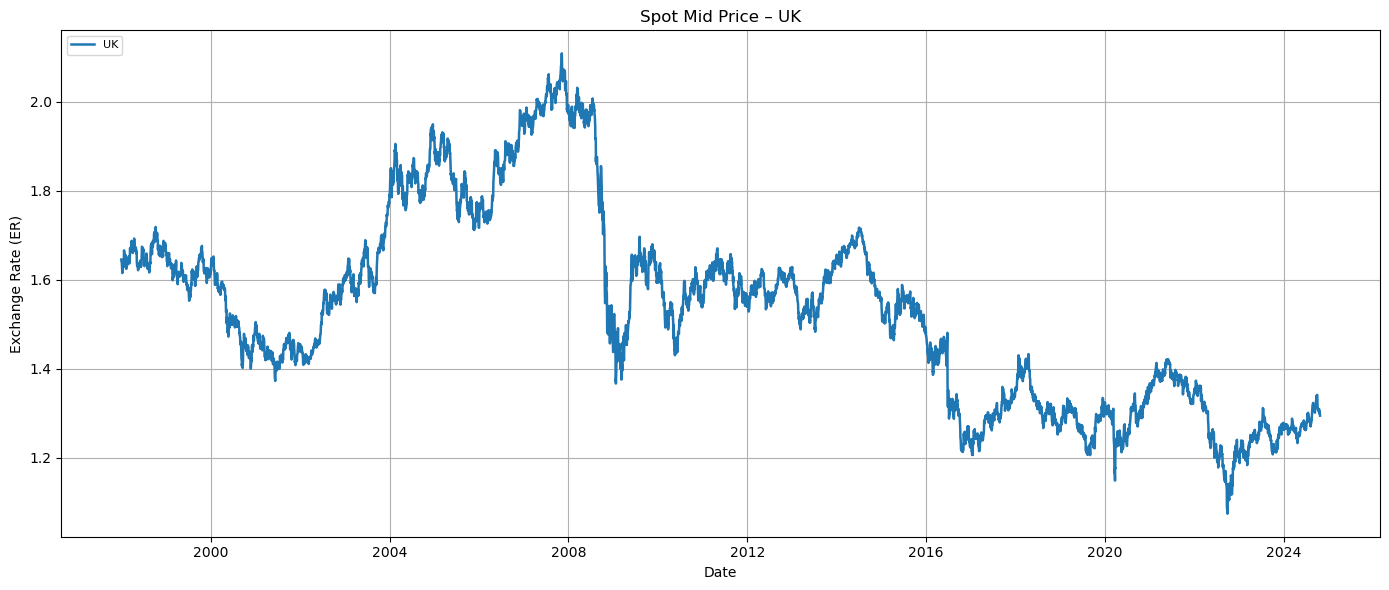

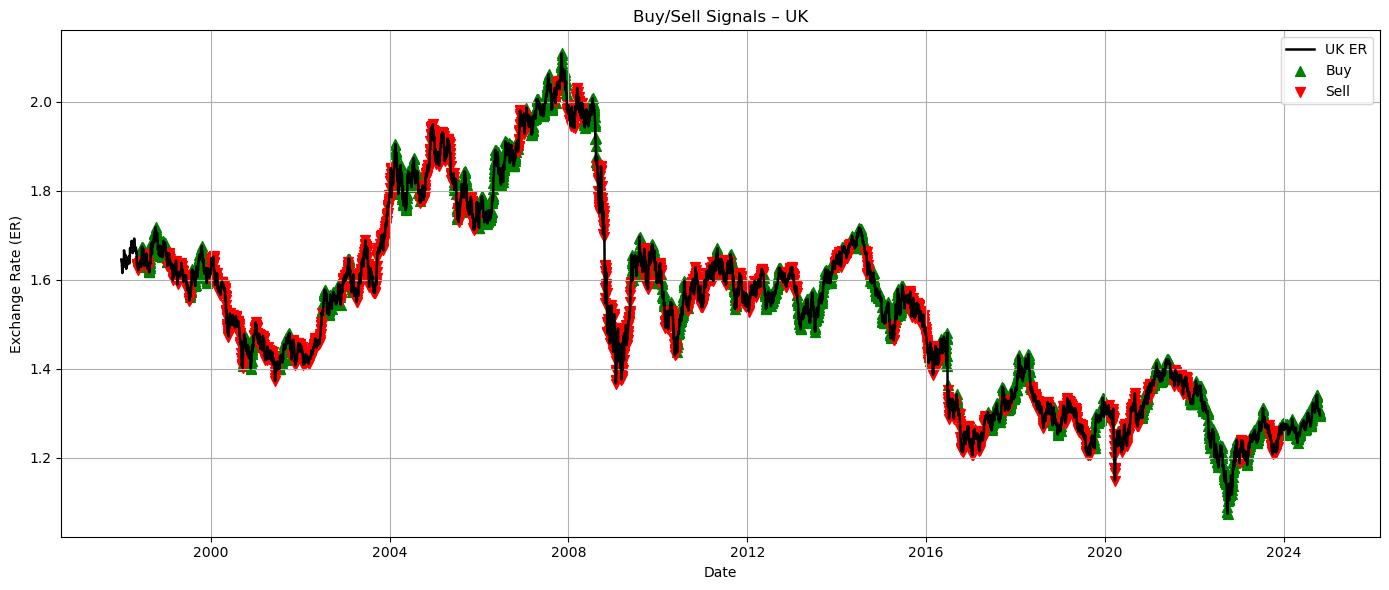

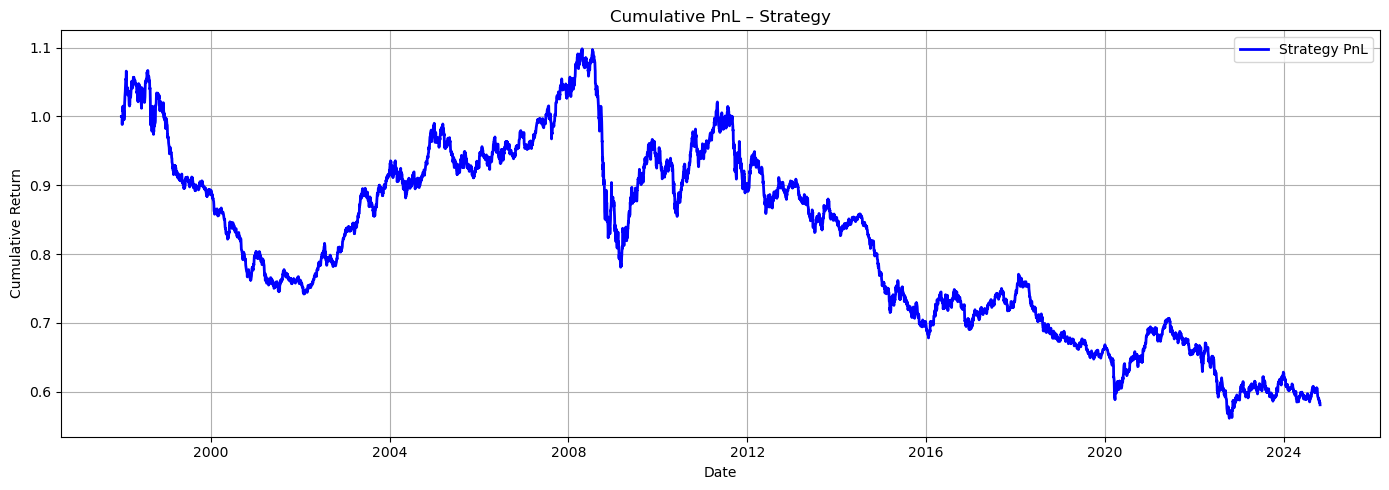

In [48]:
import matplotlib.pyplot as plt

def plot_prices(ER, currency=None):

    plt.figure(figsize=(14, 6))

    if currency is not None:
        if currency not in ER.columns:
            print(f"Currency '{currency}' not found.")
            return
        plt.plot(ER.index, ER[currency], label=currency, linewidth=1.8)
    else:
        for cur in ER.columns:
            plt.plot(ER.index, ER[cur], linewidth=1, alpha=0.8, label=cur)

    plt.title("Spot Mid Prices" if currency is None else f"Spot Mid Price – {currency}")
    plt.xlabel("Date")
    plt.ylabel("Exchange Rate (ER)")
    plt.grid(True)
    plt.legend(loc="upper left", fontsize=8, ncol=3)
    plt.tight_layout()
    plt.show()

def plot_signals(ER, signals, currency=None):

    plt.figure(figsize=(14, 6))

    if currency is not None:
        if currency not in ER.columns:
            print(f"Currency '{currency}' not found.")
            return

        price = ER[currency]
        sig   = signals[currency]

        buy_idx  = sig[sig == 1].index
        sell_idx = sig[sig == -1].index

        plt.plot(price.index, price.values, color="black", linewidth=1.8, label=f"{currency} ER")
        plt.scatter(buy_idx, price.loc[buy_idx], color="green", marker="^", s=50, label="Buy")
        plt.scatter(sell_idx, price.loc[sell_idx], color="red", marker="v", s=50, label="Sell")

    else:
        # Plot all currencies’ signals only (not their price curves)
        for cur in ER.columns:
            price = ER[cur]
            sig   = signals[cur]

            buy_idx  = sig[sig == 1].index
            sell_idx = sig[sig == -1].index

            plt.scatter(buy_idx, price.loc[buy_idx], color="green", marker="^", s=25)
            plt.scatter(sell_idx, price.loc[sell_idx], color="red", marker="v", s=25)

        plt.plot([], [], color="green", marker="^", linestyle="", label="Buy signals")
        plt.plot([], [], color="red", marker="v", linestyle="", label="Sell signals")

    plt.title("Buy/Sell Signals" if currency is None else f"Buy/Sell Signals – {currency}")
    plt.xlabel("Date")
    plt.ylabel("Exchange Rate (ER)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_pnl(strat_ret, title="Cumulative PnL – Strategy"):
    pnl = (1 + strat_ret.fillna(0)).cumprod()

    plt.figure(figsize=(14, 5))
    plt.plot(pnl.index, pnl.values, linewidth=2, color="blue", label="Strategy PnL")

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


BID, ER, OFFER = split_bid_offer(xusd_df)
curr = "UK"
plot_prices(ER, currency = curr)
plot_signals(ER, signals, currency = curr)
plot_pnl(strat_ret)


The baseline full-sample results show modest negative performance, with an annualized return of about –1.7% and a Sharpe ratio of –0.25. The drawdown profile is substantial, and the return distribution is marked by mild negative skewness and pronounced excess kurtosis, consistent with the fat-tailed behaviour characteristic of currency markets.



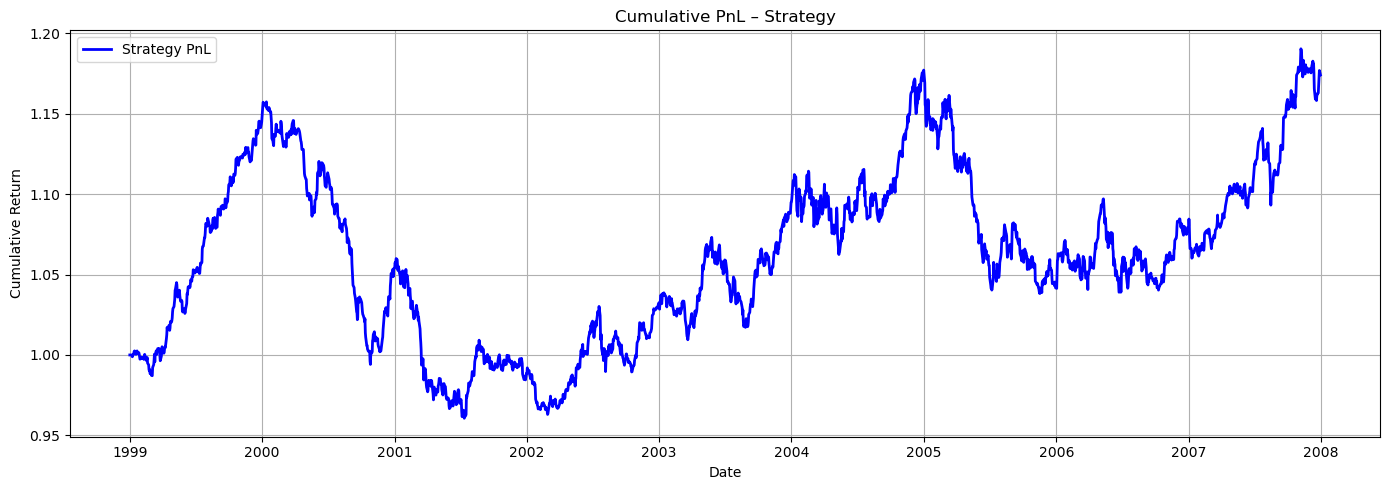

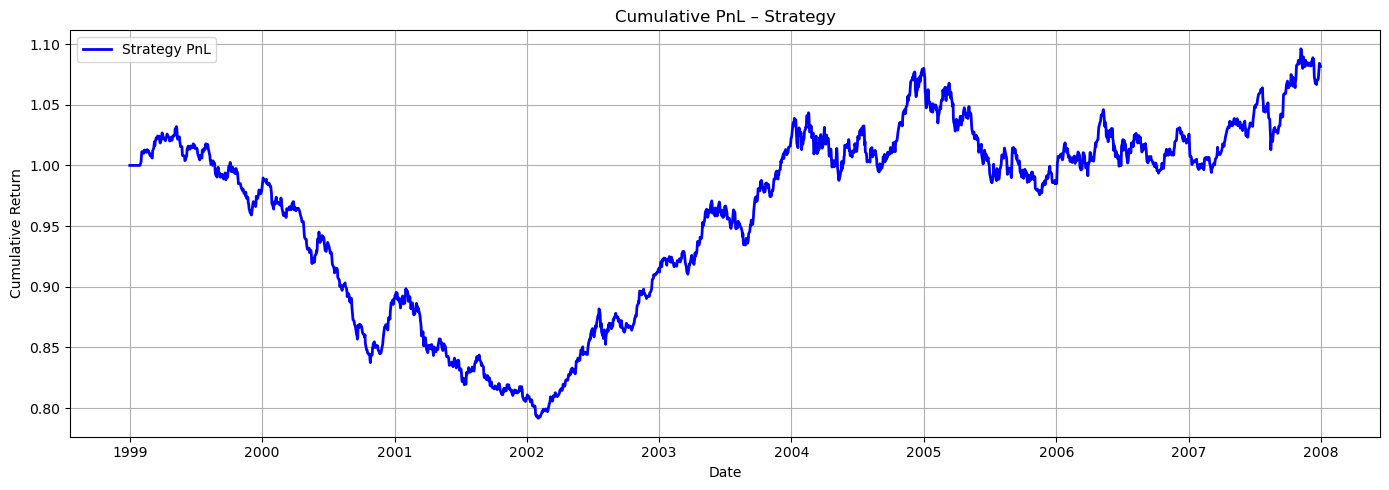

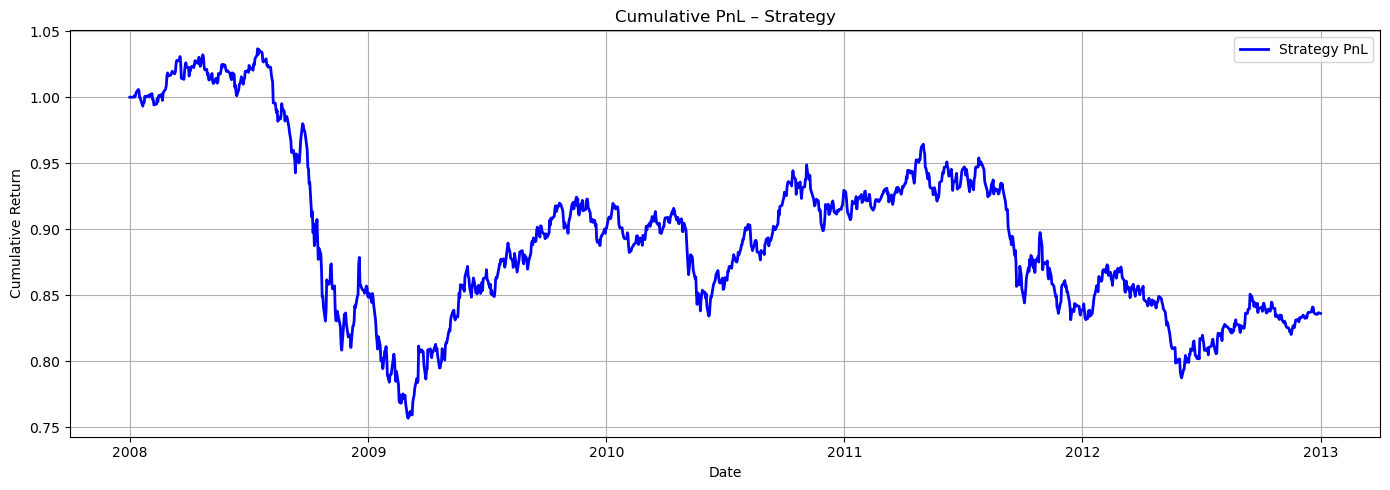

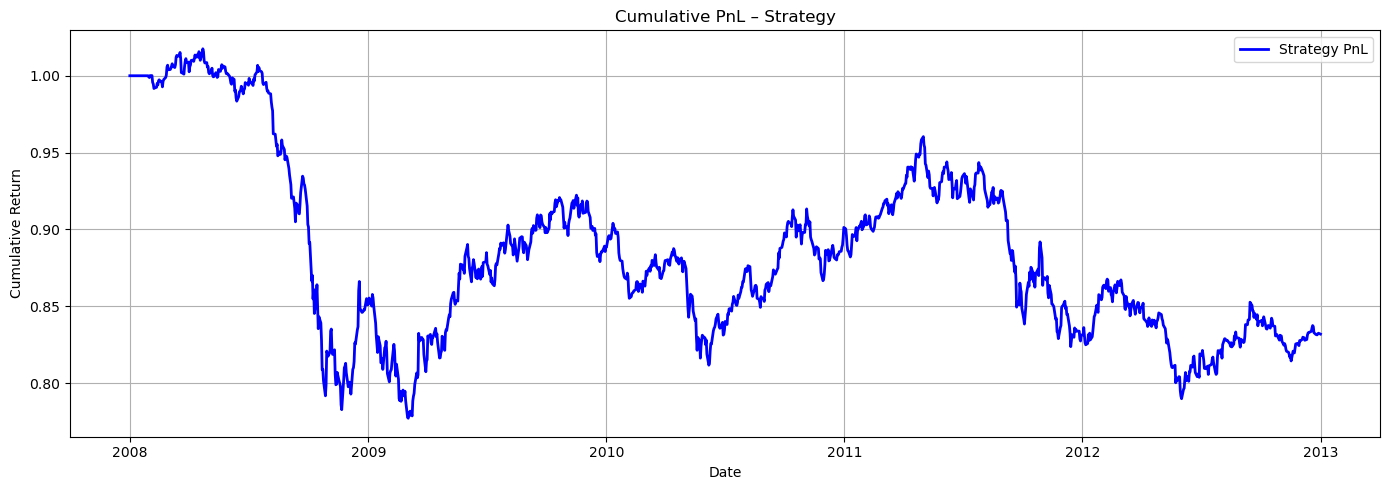

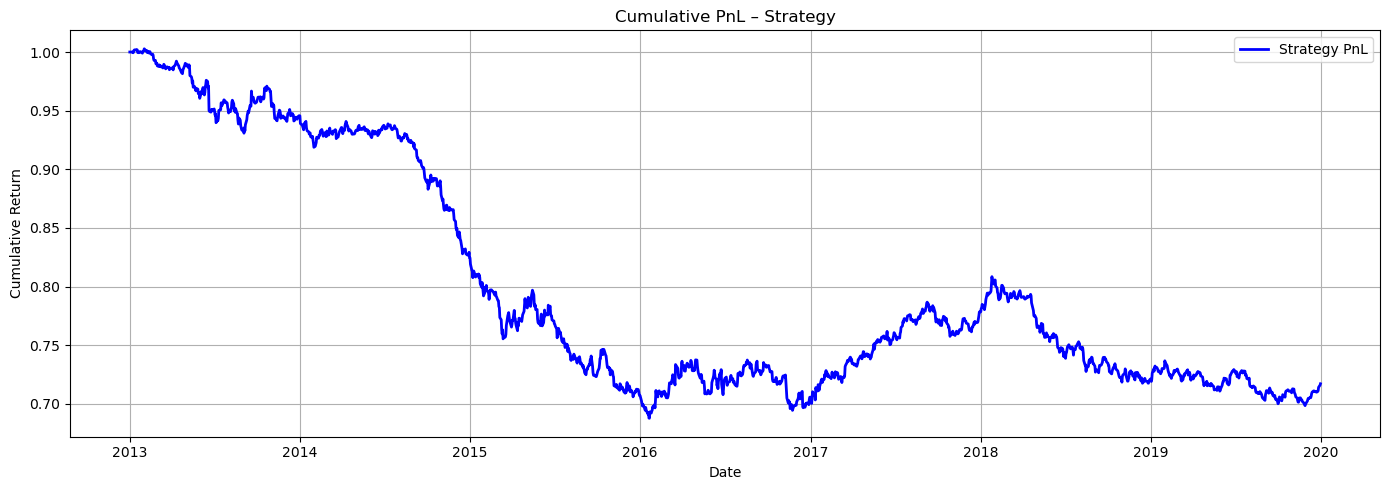

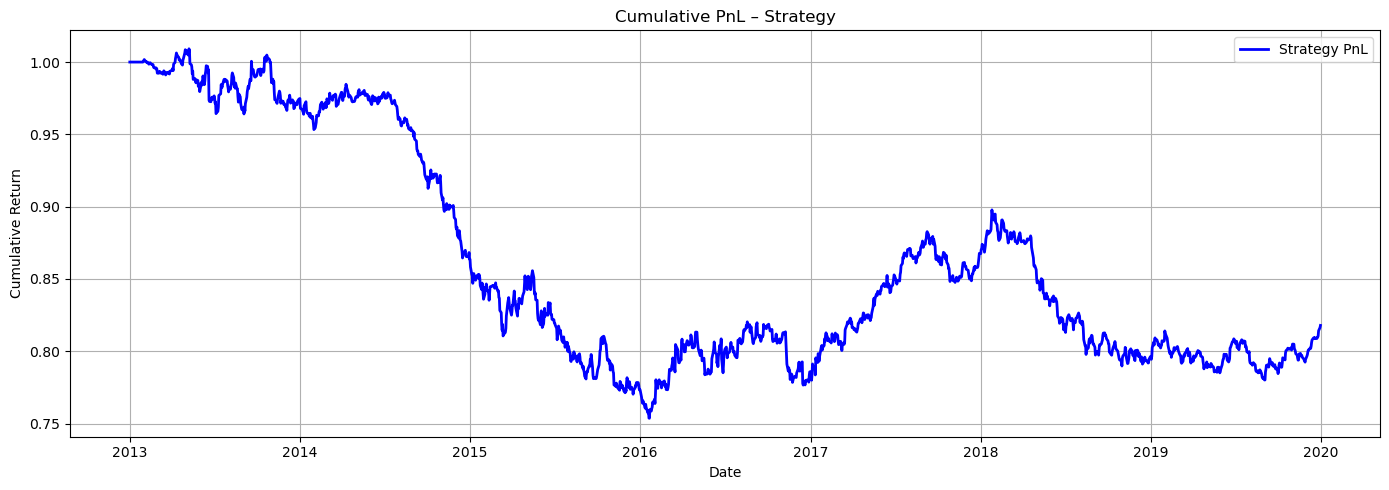

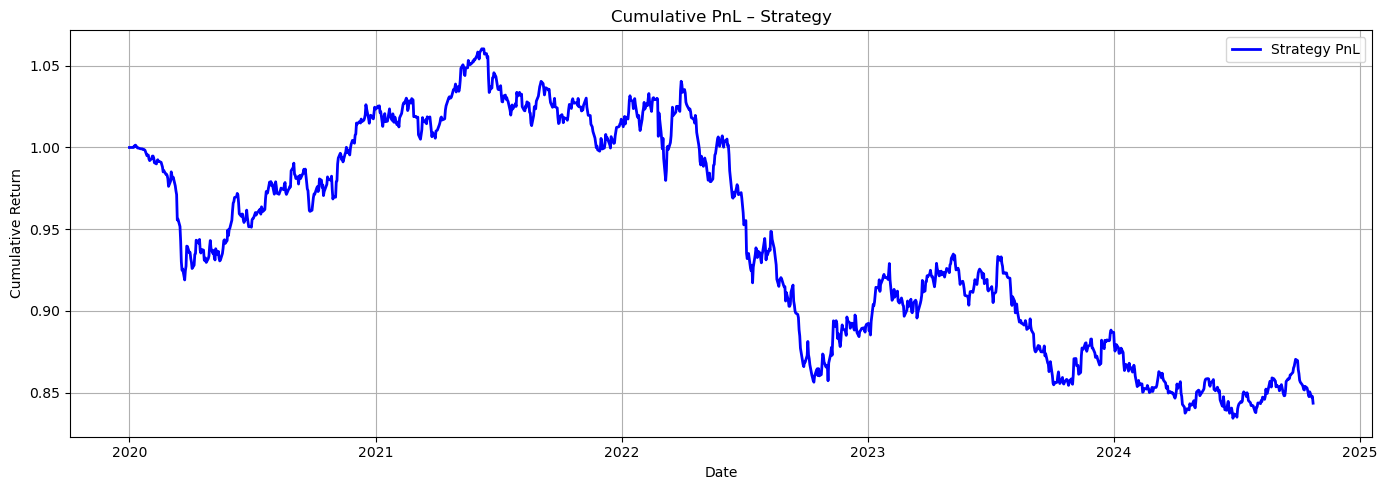

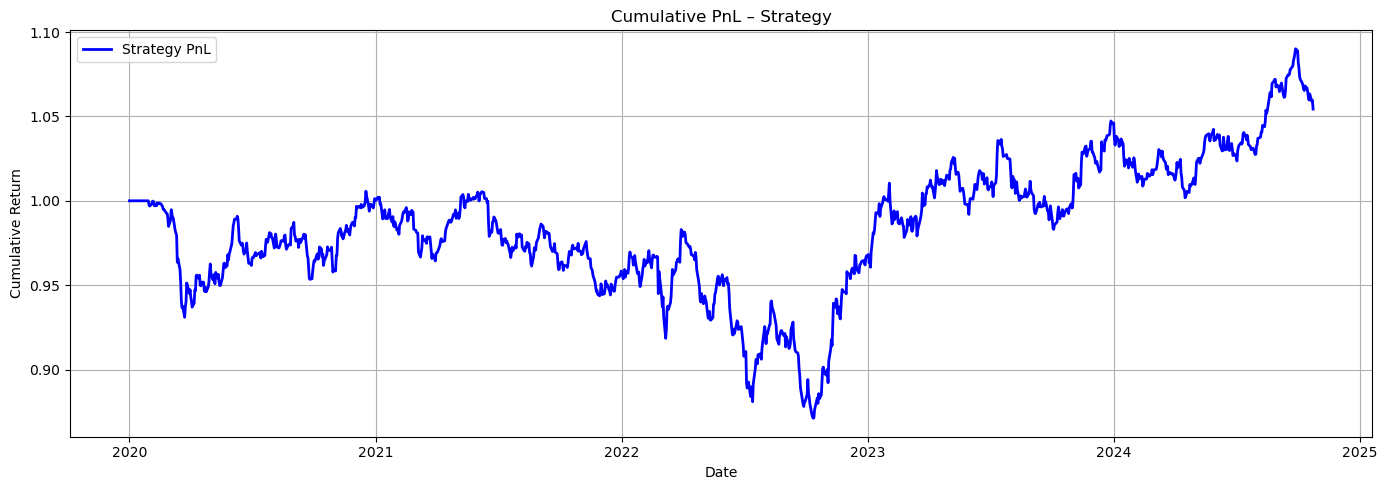

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Skewness (daily),Kurtosis (daily)
"1999-2007 | LB=4, HP=22, PCT=0.2",0.018728,0.051404,0.364336,-0.169903,-0.122593,4.218853
"1999-2007 | LB=20, HP=22, PCT=0.2",0.009793,0.051354,0.190696,-0.232991,-0.073446,4.203289
"2008-2012 | LB=4, HP=22, PCT=0.2",-0.029759,0.093202,-0.319299,-0.269846,0.046087,5.809304
"2008-2012 | LB=20, HP=22, PCT=0.2",-0.030862,0.092070,-0.335200,-0.236330,0.113875,5.972906
"2013-2019 | LB=4, HP=22, PCT=0.2",-0.043421,0.055467,-0.782814,-0.314256,0.012183,6.499054
"2013-2019 | LB=20, HP=22, PCT=0.2",-0.025876,0.055640,-0.465072,-0.253188,0.004530,6.443444
"2020-2024 | LB=4, HP=22, PCT=0.2",-0.031542,0.065006,-0.485207,-0.213174,-0.214101,5.110406
"2020-2024 | LB=20, HP=22, PCT=0.2",0.012858,0.065594,0.196033,-0.133801,-0.139922,5.207884


In [49]:
param_grid = [
    {"lookback": 4, "hold": 22, "pct": 0.2},
    {"lookback": 20, "hold": 22, "pct": 0.2},
]
subsamples = {
    "1999-2007": ("1999-01-01", "2007-12-31"), # (pre-crisis)
    "2008-2012": ("2008-01-01", "2012-12-31"), # (Financial Crisis + Euro Crisis)
    "2013-2019": ("2013-01-01", "2019-12-31"), # (QE, Low Volatility)
    "2020-2024": ("2020-01-01", "2024-12-31"), # (COVID, Inflation, QT)
}


results_sub = {}

for sub_name, (start, end) in subsamples.items():
    df_sub = xusd_df.loc[start:end]

    if len(df_sub) < 200:
        continue

    for p in param_grid:
        lb = p["lookback"]
        hd = p["hold"]
        pct = p["pct"]

        strat_ret, signals, mom,_ = momentum_strategy(
            df_sub, 
            lookback=lb,
            hold_period=hd,
            pct=pct
        )
        plot_pnl(strat_ret)

        stats = evaluate_strategy(strat_ret)

        key = f"{sub_name} | LB={lb}, HP={hd}, PCT={pct}"
        results_sub[key] = stats

subsample_comparison = pd.DataFrame(results_sub).T
subsample_comparison


The subsample analysis reveals a pattern consistent with empirical findings in the literature. Momentum performs relatively well in the pre-crisis period (1999–2007), delivering positive returns with reasonable risk-adjusted performance. However, the strategy deteriorates markedly during and after the 2008 financial crisis, with negative performance persisting through the low-volatility, policy-driven environment of the 2013–2019 period. This degradation aligns with well-documented observations that carry and momentum strategies suffered structural breaks post-2008, partly due to deleveraging, increased funding constraints, and reduced dispersion in macroeconomic fundamentals.

Interestingly, the post-2020 sample shows mixed behaviour. Short-horizon momentum remains weak for the four-day lookback, yet a longer lookback (20 days) improves performance modestly, suggesting that trend-following signals may have experienced a partial recovery in the higher-volatility environment associated with COVID-19, inflation shocks, and monetary tightening.

Overall, the implemented framework captures the essential mechanics of FX momentum and provides a transparent basis for evaluating its behaviour across regimes. The results underline a central theme in empirical international finance: the profitability of cross-sectional FX factors is highly sensitive to macroeconomic conditions, market structure, and periods of stress, and has not been stable over time.

In [31]:
def split_bid_offer(df):
    bid_cols   = [c for c in df.columns if c.endswith("_BID")]
    er_cols    = [c for c in df.columns if c.endswith("_ER")]
    offer_cols = [c for c in df.columns if c.endswith("_OFFER")]

    BID   = df[bid_cols].copy()
    ER    = df[er_cols].copy()
    OFFER = df[offer_cols].copy()

    BID.columns   = [c.replace("_BID", "") for c in bid_cols]
    ER.columns    = [c.replace("_ER", "") for c in er_cols]
    OFFER.columns = [c.replace("_OFFER", "") for c in offer_cols]

    return BID, ER, OFFER

def harmonize_forward(df_forward):
    currencies = sorted({c.split("_")[0] for c in df_forward.columns})

    F_bid   = pd.DataFrame(index=df_forward.index)
    F_mid   = pd.DataFrame(index=df_forward.index)
    F_offer = pd.DataFrame(index=df_forward.index)

    for cur in currencies:
        bid_c   = cur + "_BID"
        er_c    = cur + "_ER"
        off_c   = cur + "_OFFER"

        if bid_c in df_forward.columns:
            F_bid[cur] = df_forward[bid_c]
        if er_c in df_forward.columns:
            F_mid[cur] = df_forward[er_c]
        if off_c in df_forward.columns:
            F_offer[cur] = df_forward[off_c]

    return F_bid, F_mid, F_offer

def ppp_strategy(df_spot, df_forward, hold_period=22, pct=0.3):

    BID, ER, OFFER = split_bid_offer(df_spot)

    # --- harmonise forward prices ---
    F_bid, F_mid, F_offer = harmonize_forward(df_forward)

    # --- align time indices ---
    BID   = BID.reindex(index=df_forward.index)
    ER    = ER.reindex(index=df_forward.index)
    OFFER = OFFER.reindex(index=df_forward.index)

    # --- select common currencies only ---
    common = ER.columns.intersection(F_mid.columns)

    ER      = ER[common]
    BID     = BID[common]
    OFFER   = OFFER[common]
    F_mid   = F_mid[common]

    # --- PPP mispricing ---
    value = F_mid / ER - 1

    dates  = value.index
    assets = value.columns
    signals = pd.DataFrame(0, index=dates, columns=assets)

    rebalance_dates = dates[::hold_period]

    for t in rebalance_dates:
        today = value.loc[t].dropna()
        if today.empty:
            continue

        n = len(today)
        k = int(np.floor(n * pct))

        underval = today.nsmallest(k).index
        overval  = today.nlargest(k).index

        signals.loc[t, underval] = 1
        signals.loc[t, overval]  = -1

    signals = signals.replace(0, np.nan).ffill().fillna(0)

    # --- execution with bid–ask spreads ---
    long_ret  = np.log(BID)   - np.log(OFFER.shift(1))
    short_ret = np.log(OFFER) - np.log(BID.shift(1))

    executed = (
        (signals.shift(1) == 1)  * long_ret +
        (signals.shift(1) == -1) * short_ret
    )

    strat_ret = executed.mean(axis=1)

    return strat_ret, signals, value


ppp_ret_1M, ppp_sig_1M, value_1M = ppp_strategy(
    xusd_df,
    forward_1M,
    hold_period=10,
    pct=0.3
)

ppp_ret_1W, ppp_sig_1W, value_1W = ppp_strategy(
    xusd_df,
    forward_1W,
    hold_period=22,
    pct=0.5
)


stats_ppp_1M = evaluate_strategy(ppp_ret_1M)
stats_ppp_1W = evaluate_strategy(ppp_ret_1W)

print("PPP Strategy 1M:\n", stats_ppp_1M)
print("\nPPP Strategy 1W:\n", stats_ppp_1W)


PPP Strategy 1M:
 Annualized Return        -0.332595
Annualized Volatility     0.316678
Sharpe Ratio             -1.050262
Max Drawdown             -0.367144
Skewness (daily)         -6.517121
Kurtosis (daily)         65.179846
dtype: float64

PPP Strategy 1W:
 Annualized Return        -0.424424
Annualized Volatility     0.475387
Sharpe Ratio             -0.892797
Max Drawdown             -0.501448
Skewness (daily)         -4.460222
Kurtosis (daily)         40.091836
dtype: float64


The results obtained for both the 1-month and 1-week PPP strategies are unequivocally poor. Annualized returns are sharply negative (approximately -33% for the 1-month horizon and -42% for the 1-week horizon), while volatility remains elevated. The Sharpe ratios, well below zero, confirm that the strategy systematically destroys value rather than generating risk-adjusted performance.

The distributional properties make the conclusion even more severe. The strategies exhibit extremely negative skewness and abnormally high kurtosis, indicating that losses are not only frequent but also dominated by large adverse moves. This is consistent with the fact that PPP is a theoretical long-run parity condition that adjusts slowly over time; when applied to short horizons such as 1-week or 1-month forwards, it offers no exploitable predictability and exposes the portfolio to substantial noise and microstructure effects.

The execution mechanism further amplifies these losses. Because positions are taken on currencies classified as “undervalued” or “overvalued” based on the forward discount, the strategy frequently trades against persistent short-term trends. Combined with the bid–ask structure, this results in systematic slippage. Every rebalancing effectively penalizes the portfolio, and the strategy fails to recover from the cumulative impact of transaction costs and misaligned signals.

In short, the empirical evidence shows that a high-frequency PPP-based allocation is not just ineffective but actively harmful. It consistently positions the investor on the wrong side of short-term currency dynamics, suffers disproportionately during episodes of market stress, and offers no compensating periods of outperformance. The strategy performs so poorly that it should be considered non-viable in its current form and does not meet even minimal standards of practical implementability.